In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import geopy.distance
pd.set_option('display.max_columns', None)


In [12]:
credit_df = pd.read_csv('credit_card_transactions.csv')

In [13]:
credit_df.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0


# EDA

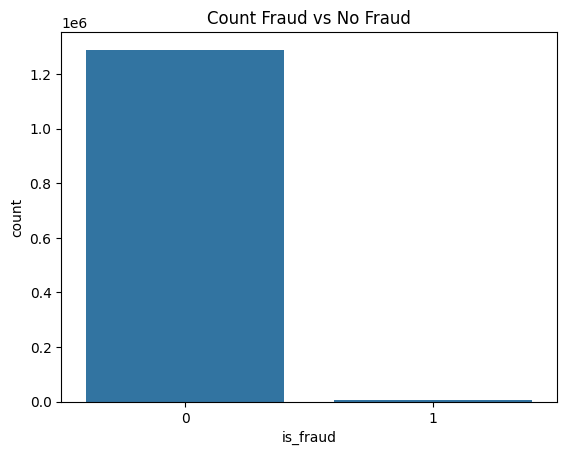

In [14]:
sns.countplot(x='is_fraud', data=credit_df)
plt.title('Count Fraud vs No Fraud')
plt.show()

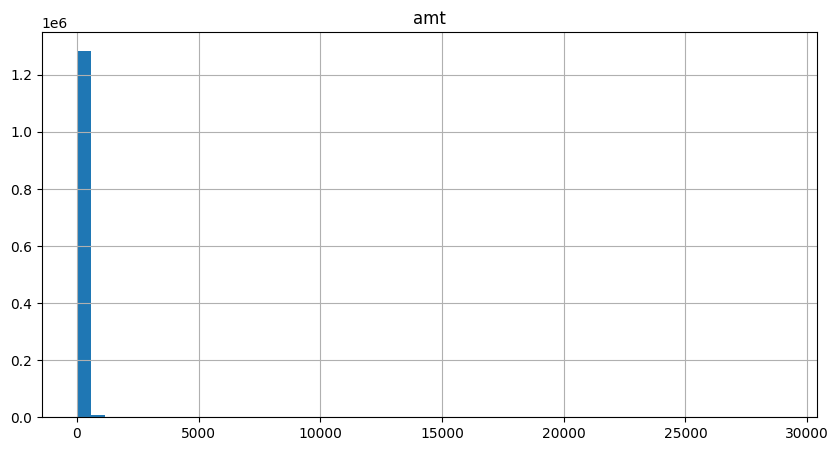

In [15]:
credit_df[['amt']].hist(bins=50, figsize=(10,5))
plt.show()

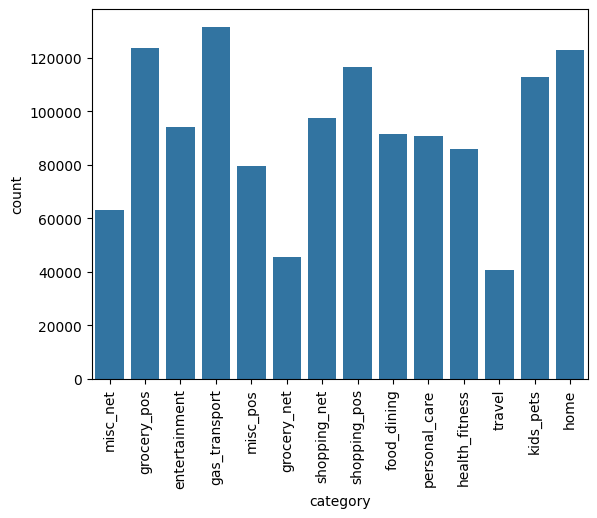

In [16]:
sns.countplot(x='category', data=credit_df).\
tick_params(axis='x', labelrotation=90)

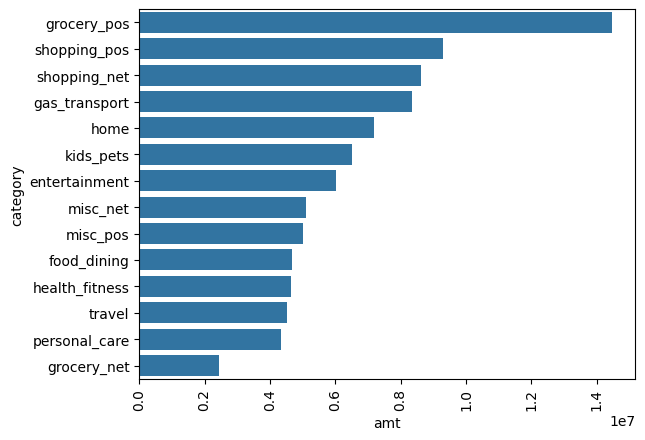

In [17]:
df = credit_df.groupby('category')['amt'].sum().reset_index().sort_values('amt', ascending=False)
sns.barplot(x='amt', y='category', data=df).\
tick_params(axis='x', labelrotation=90)

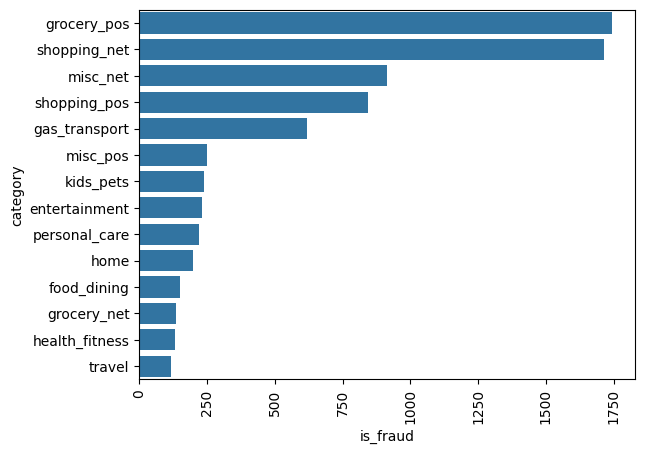

In [18]:
df = credit_df.groupby('category')['is_fraud'].sum().reset_index().sort_values('is_fraud', ascending=False)
sns.barplot(x='is_fraud', y='category', data=df).\
tick_params(axis='x', labelrotation=90)

<Axes: xlabel='is_fraud', ylabel='state'>

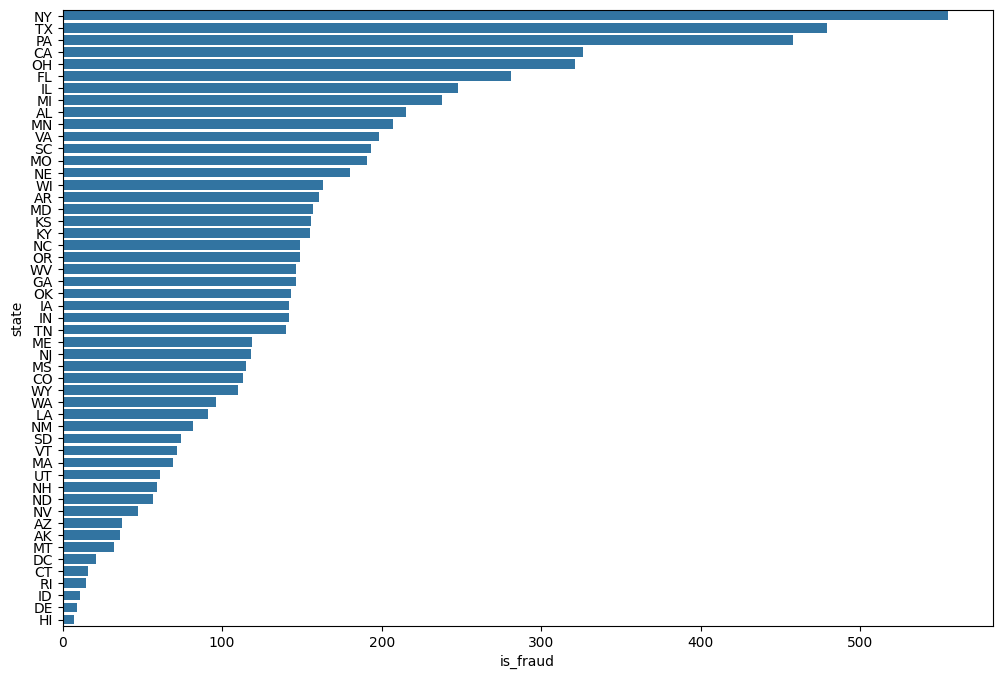

In [19]:
df = credit_df.groupby('state')['is_fraud'].sum().reset_index().sort_values('is_fraud', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='is_fraud', y='state', data=df)

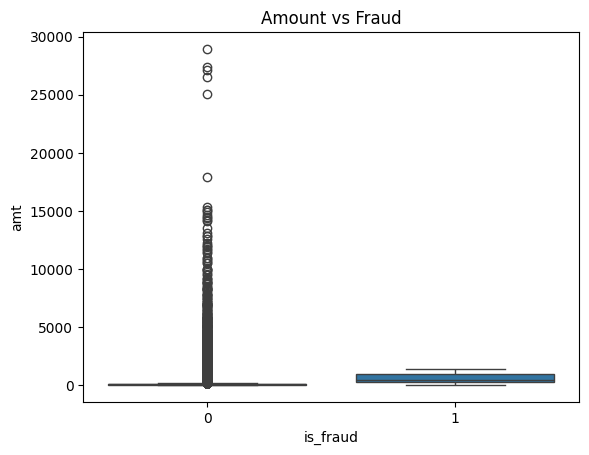

In [20]:
sns.boxplot(x='is_fraud', y='amt', data=credit_df)
plt.title('Amount vs Fraud')
plt.show()

# Feature Engineering

First of all, we will create a new column that is the calcule betwenn lat / lon of the merchant vs lat / lon of the customer
In a second moment I could calculate how munch transactions the customer has on this merchant
and I can see if the date/time of the buy is in a point that sounds suspect (maybe build a time column)

## Column Distance

In [38]:
credit_df['coords'] = credit_df.apply(lambda row: f"{row['lat']},{row['long']}", axis = 1)
credit_df['merch_coords'] = credit_df.apply(lambda row: f"{row['merch_lat']},{row['merch_long']}", axis = 1)

In [40]:
credit_df['distance'] = credit_df.apply(lambda row: geopy.distance.geodesic(row['coords'], row['merch_coords']).km, axis=1)

In [42]:
credit_df[['coords','merch_coords','distance']]

,coords,merch_coords,distance
0,"36.0788,-81.1781","36.011293,-82.048315",78.773821
1,"48.8878,-118.2105","49.159047,-118.186462",30.216618
2,"42.1808,-112.262","43.150704,-112.154481",108.102912
3,"46.2306,-112.1138","47.034331,-112.561071",95.685115
4,"38.4207,-79.4629","38.674999,-78.632459",77.702395
...,...,...,...
1296670,"37.7175,-112.4777","36.841266,-111.69076499999998",119.696415
1296671,"39.2667,-77.5101","38.906881,-78.246528",75.202184
1296672,"32.9396,-105.8189","33.619513,-105.130529",98.987927
1296673,"43.3526,-102.5411","42.78894,-103.24116",84.688356


# Frequency

# Age

In [55]:
today = datetime.today()

credit_df['age'] = pd.to_datetime(credit_df['dob']).apply(lambda dob: today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day)))

# Purchase Time

In [49]:
credit_df['purchase_time'] = pd.to_datetime(credit_df['trans_date_trans_time']).dt.strftime('%H:%M')

In [50]:
credit_df_transformed = credit_df['cc_num','purchase_time','merchant','category','amt', 'first','last','gender','street','city','state','zip','coords','city_pop','job','dob','trans_num','unix_time','merch_coords','distance']

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,coords,merch_coords,distance,purchase_time
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0,"36.0788,-81.1781","36.011293,-82.048315",78.773821,00:00
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN,"48.8878,-118.2105","49.159047,-118.186462",30.216618,00:00
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0,"42.1808,-112.262","43.150704,-112.154481",108.102912,00:00
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN,"46.2306,-112.1138","47.034331,-112.561071",95.685115,00:01
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0,"38.4207,-79.4629","38.674999,-78.632459",77.702395,00:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,NaN,"37.7175,-112.4777","36.841266,-111.69076499999998",119.696415,12:12
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,22630.0,"39.2667,-77.5101","38.906881,-78.246528",75.202184,12:12
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,88351.0,"32.9396,-105.8189","33.619513,-105.130529",98.987927,12:12
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,69367.0,"43.3526,-102.5411","42.78894,-103.24116",84.688356,12:13
